# Mobility in Puerto Rico following Hurricane Maria

This file includes steps for:
* Creating driving network (graph)
* Connecting points of origin and destination to road network
* Assigning driving times for all road segments on the road network
* Measuring walking distance and time from points of origin to the road network using Tobler's hiking function (Euclidean distance & elevation)

### Configure script.

In [1]:
import os, sys
GISFolder = os.getcwd()

In [2]:
# Note: gostnet.py and associated files are in the current working directory.

os.getcwd()

'C:\\Users\\grace\\GIS\\puerto rico'

In [3]:
import GOSTnet as gn # Python couldn't find the module. Moved it into C:\Users\grace\Anaconda3\envs\access\Lib\site-packages
import pandas as pd
from geopandas import GeoDataFrame
import shapely
from shapely.geometry import Point, box
import geopandas as gpd
import osmnx as ox
import networkx as nx
import numpy as np
import rasterio as rt

In [4]:
# Didn't use in this iteration:
import fiona
import peartree
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob

In [5]:
pth = os.path.join(GISFolder, "data\working files\gn")
pth

'C:\\Users\\grace\\GIS\\puerto rico\\data\\working files\\gn'

### Prepare and clean the data.

In [ ]:
# OSM road network is in WGS84. Projected each dataset to match.
# Multi-point shapefiles don't read well. Re-created shapefile from csv with geopandas for each offending file.

In [6]:
%qtconsole

In [10]:
dfH = os.path.join(GISFolder, "data\working files\gn", "hospitals1.csv")
dfH = pd.read_csv(dfH)
geometry = [Point(xy) for xy in zip(dfH.X, dfH.Y)]
crs = {'init': 'epsg:4326'} 
inH = GeoDataFrame(dfH, crs=crs, geometry=geometry)
inH.to_file(driver='ESRI Shapefile', filename='hospitals2.shp') 
# 75 observations.
inH.head()

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,7990,400631,HOSP GENERAL CASTANER INC,KM 64-2 ROUTE 135,CASTAÑER,PR,631,NOT AVAILABLE,(787) 829-5010,GENERAL ACUTE CARE,...,NOT AVAILABLE,115,NOT AVAILABLE,72,NON-PROFIT,-999,24,NOT AVAILABLE,NOT AVAILABLE,POINT (-66.83318174999999 18.18101307)
1,7995,900605,HOSPITAL BUEN SAMARITANO,CARR #2 KM 141-1 AVE SEVERIANO CUEVAS #18 BO. ...,AGUADILLA,PR,605,NOT AVAILABLE,(787) 658-0000,GENERAL ACUTE CARE,...,http://www.hbspr.org,8,NOT AVAILABLE,72,NON-PROFIT,-999,154,NOT AVAILABLE,NOT AVAILABLE,POINT (-67.15088511 18.44280934)
2,7996,1000676,HOSP SAN CARLOS BORROMEO,550 CONCEPCION VERA AYALA,MOCA,PR,676,NOT AVAILABLE,(787) 877-8000,GENERAL ACUTE CARE,...,http://www.hscbpr.org,148,NOT AVAILABLE,72,NON-PROFIT,-999,106,NOT AVAILABLE,NOT AVAILABLE,POINT (-67.10996904 18.39019435)
3,8007,3400705,HOSP GENERAL MENONITA - AIBONITO,C/JOSE C VAZQUEZ - SALIDA BO CAONILLA,AIBONITO,PR,705,NOT AVAILABLE,(787) 735-8001,GENERAL ACUTE CARE,...,http://www.hospitalmenonita.com/,11,NOT AVAILABLE,72,PROPRIETARY,-999,-999,NOT AVAILABLE,NOT AVAILABLE,POINT (-66.26170737 18.14379446)
4,7988,100614,HOSP METROPOLITANO DR SUSONI,55 NICOMEDES RIVERA STREET,ARECIBO PUEBLO,PR,614,NOT AVAILABLE,(787) 650-1030,GENERAL ACUTE CARE,...,NOT AVAILABLE,19,NOT AVAILABLE,72,PROPRIETARY,-999,138,NOT AVAILABLE,NOT AVAILABLE,POINT (-66.71691497 18.47328848)


In [11]:
dfD = os.path.join(GISFolder, "data\working files\gn", "dialysis2.csv")
dfD = pd.read_csv(dfD)
geometry = [Point(xy) for xy in zip(dfD.long, dfD.lat)]
crs = {'init': 'epsg:4326'} 
inD = GeoDataFrame(dfD, crs=crs, geometry=geometry)
inD.to_file(driver='ESRI Shapefile', filename='dialysis2wgs84.shp') 
# Original dataset had 47 individual observations. Two of these were duplicates, making 45 total.
inD.head()

,Provider Number,Facility Name,lat,long,Address Line 1,City,Zip,County,Chain Organization,# of Dialysis Stations,geometry
0,402513,FMC AGUADILLA DIALYSIS CENTER,18.468786,-67.118260,CARR 459 KM 0.7 BO CAMASEYES,AGUADILLA,603,AGUADILLA,FRESENIUS MEDICAL CARE,24,POINT (-67.1182603 18.4687862)
1,402519,"ATLANTIS HEALTH CARE GROUP (PUERTO RICO), INC.",18.391264,-67.117501,18 AVE SEVERIANO CUEVAS,AGUADILLA,605,AGUADILLA,ATLANTIS HEALTHCARE GROUP,25,POINT (-67.11750090000001 18.3912641)
2,402508,FMC ARECIBO DIALYSIS CENTER,18.423322,-66.739066,1072 AVENUE MIRAMAR,ARECIBO,612,ARECIBO,FRESENIUS MEDICAL CARE,28,POINT (-66.7390661 18.4233218)
3,402529,FMC ARECIBO NORTE DIALYSIS CENTER,18.388935,-66.734479,HOSPITAL PAVIA ARECIBO,ARECIBO,612,ARECIBO,FRESENIUS MEDICAL CARE,19,POINT (-66.7344786 18.3889353)
4,402543,FMC SANTA JUANITA,18.368058,-66.159749,URB SANTA JUANITA,BAYAMON,956,BAYAMON,FRESENIUS MEDICAL CARE,33,POINT (-66.15974900000001 18.3680575)


In [12]:
dfP = os.path.join(GISFolder, "data\working files\gn", "pharmacies1.csv")
dfP = pd.read_csv(dfP)
geometry = [Point(xy) for xy in zip(dfP.X, dfP.Y)]
crs = {'init': 'epsg:4326'} 
inP = GeoDataFrame(dfP, crs=crs, geometry=geometry)
inP.to_file(driver='ESRI Shapefile', filename='pharm3wgs84.shp') 
# 965 observations.
inP.head()

,FID,ID,SECCLASS,NAME,TELEPHONE,ADDRESS,ADDRESS2,CITY,STATE,ZIP,...,HEALTH_95,PROVID_96,PROVID_97,HEALTH_99,PROVID_100,PROVID_101,HEALTH_103,PROVID_104,PROVID_105,geometry
0,22001,11711758,UNCLASSIFIED,FARMACIA VILLA ESPERANZA,787-708-1300,AVENIDA EMILIANO POL 489,URBANIZACION LA CUMBRE,SAN JUAN,PR,926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.074557 18.3609946)
1,22002,11645399,UNCLASSIFIED,FARMACIA YARIMAR,787-792-3196,CALLE 31 904 SUROESTE,BARRIO LAS LOMAS,SAN JUAN,PR,921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.0949918 18.3904596)
2,22003,11656886,UNCLASSIFIED,KMART - 4490,787-792-7708,AVENIDA FRANKLIN D ROOSEVELT 1,URBANIZACION CAPARRA HEIGHTS SAN PATRICIO PLAZA,GUAYNABO,PR,968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.1054762 18.409322)
3,22004,11652356,UNCLASSIFIED,ONE STOP PRESCRIPTION,787-977-2007,AVENIDA JOSE DE DIEGO 114,SUPERMERCADO EL MONTE,SANTURCE,PR,907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.064924 18.4514286)
4,22005,11697024,UNCLASSIFIED,FARMACIA CARIDAD,787-253-7195,CALLE LUNA WD22,URBANIZACION LOS ANGELES,CAROLINA,PR,979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.00932229999999 18.4296024)


#### Clean WorldPop data for network analysis.

All cleaning for WorldPop detailed below performed in R and QGIS:

1) Removed observations where population = 0, leaving 1,075,783 observations. (1,082,378 original observations.) 

R: tidyverse filter()

2) Each WorldPop feature is assigned a unique ID ("wid") and its corresponding municipal ID ("mid") and municipio name.

R: 1:nrow()
    
QGIS: Spatial join.
Note: some coastal points fall outside of the municipio boundaries. To resolve, created a buffer of all municipal features, and merged those buffer zones onto the municipalities polygon shapefile.

In [ ]:
dfO = os.path.join(GISFolder, "data\working files\gn", "wpop1.csv")
dfO = pd.read_csv(dfO)
geometry = [Point(xy) for xy in zip(dfO.X, dfO.Y)]
crs = {'init': 'epsg:4326'} 
inO = GeoDataFrame(dfO, crs=crs, geometry=geometry)
inO.to_file(driver='ESRI Shapefile', filename='wpop2wgs84.shp') 

#### If starting new session, load the cleaned data from disk.

In [6]:
inputOrigins = os.path.join(pth, "wpop3wgs84.shp")

In [10]:
inputD = os.path.join(pth, "dialysis2wgs84.shp")
inputH = os.path.join(pth, "hospitals2.shp")
inputP = os.path.join(pth, "pharm3wgs84.shp")

In [7]:
inO = gpd.read_file(inputOrigins) # Around 1 million rows

In [11]:
inD = gpd.read_file(inputD) # 45 rows
inH = gpd.read_file(inputH) # 75 rows
inP = gpd.read_file(inputP) # Around 1000 rows

In [14]:
inP.head()

,FID,ID,NAME,ADDRESS,ADDRESS2,CITY,STATE,ZIP,ZIPP4,COUNTY,FIPS,X,Y,geometry
0,22001,11711758,FARMACIA VILLA ESPERANZA,AVENIDA EMILIANO POL 489,URBANIZACION LA CUMBRE,SAN JUAN,PR,926,NaN,SAN JUAN,72127,-66.074557,18.360995,POINT (-66.07456 18.36099)
1,22002,11645399,FARMACIA YARIMAR,CALLE 31 904 SUROESTE,BARRIO LAS LOMAS,SAN JUAN,PR,921,NaN,SAN JUAN,72127,-66.094992,18.390460,POINT (-66.09499 18.39046)
2,22003,11656886,KMART - 4490,AVENIDA FRANKLIN D ROOSEVELT 1,URBANIZACION CAPARRA HEIGHTS SAN PATRICIO PLAZA,GUAYNABO,PR,968,NaN,GUAYNABO,72061,-66.105476,18.409322,POINT (-66.10548 18.40932)
3,22004,11652356,ONE STOP PRESCRIPTION,AVENIDA JOSE DE DIEGO 114,SUPERMERCADO EL MONTE,SANTURCE,PR,907,NaN,SAN JUAN,72127,-66.064924,18.451429,POINT (-66.06492 18.45143)
4,22005,11697024,FARMACIA CARIDAD,CALLE LUNA WD22,URBANIZACION LOS ANGELES,CAROLINA,PR,979,NaN,CAROLINA,72031,-66.009322,18.429602,POINT (-66.00932 18.42960)


In [15]:
inO.head()

,wpop,xmid,xxmunicipi,wid,municipio,mid,geometry
0,0.818646,0.0,Adjuntas,1,Adjuntas,0.0,POINT (-66.79433 18.24981)
1,0.731308,0.0,Adjuntas,2,Adjuntas,0.0,POINT (-66.79350 18.24981)
2,0.642141,0.0,Adjuntas,3,Adjuntas,0.0,POINT (-66.79267 18.24981)
3,0.612746,0.0,Adjuntas,4,Adjuntas,0.0,POINT (-66.79183 18.24981)
4,0.699177,0.0,Adjuntas,5,Adjuntas,0.0,POINT (-66.79017 18.24981)


#### Generate shape from shapefile for the bounding box

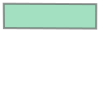

In [16]:
aoi = r'prboundingwgs84.shp' 
# Graph didn't populate on the smaller islands when using the Puerto Rico admin boundary.
# Created a rectangular bounding box (in QGIS) to use as the AOI instead.
shp = gpd.read_file(os.path.join(pth, aoi))
bound = shp.geometry.iloc[0]
bound # Check that it's a rectangle (short and wide)

### 2. Get driving network for all islands in Puerto Rico. 

This step pulls live OpenStreetMap road data. Origins and health facilities are not yet incorporated. Travel measured in length (meters).

In [55]:
gDrive = ox.graph_from_polygon(bound, network_type= 'drive')
# This took about 8 minutes on a fast machine.
# Note: length is measured in meters.

In [56]:
# Save all road nodes (points on the road) to file.
gDrive_node_gdf = gn.node_gdf_from_graph(gDrive)
gDrive_node_gdf.to_csv(os.path.join(pth, 'drive_dist_node.csv'))

#### Add a baseline time measure using a speed dictionary.

In [57]:
speed_dict = {
                'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

networkType = 'drive'
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type = networkType, speed_dict = speed_dict)
# Note: time is in seconds.

#### Save road nodes and road edges to file. Edges contains time measure.

In [58]:
edges = gn.edge_gdf_from_graph(gTime)
nodes = gn.node_gdf_from_graph(gTime)
edges.to_csv(os.path.join(pth, 'drive_time_edge.csv'))
nodes.to_csv(os.path.join(pth, 'drive_time_node.csv'))

In [59]:
nodes.info()
# There are 171,850 road nodes in Puerto Rico that an origin cell can snap to.

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 171850 entries, 0 to 171849
Data columns (total 7 columns):
node_ID     171850 non-null int64
ref         407 non-null object
osmid       171850 non-null int64
y           171850 non-null float64
x           171850 non-null float64
highway     3358 non-null object
geometry    171850 non-null geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 10.5+ MB


In [60]:
?gn.save

In [61]:
# Save a pickle of the graph with the time measure for easy recall.
gn.save(gTime, 'gTime', edges = False, nodes = False) # Switched this to working directory (removed  pth, from before edges=) but haven't tried it

In [8]:
#%% If starting new session, reload graph from file
gTime = nx.read_gpickle("gTime.pickle")

### 3. Origins and destinations

Measure distance from origin/destination to nearest node and save to file.

In [23]:
# pandana_snap calculates the great circle distance between the origin and nearest road node.
# Took maybe 1 min for Origins. Much shorter for the rest.
# Adding x,y fields on origins file for later use with add_elevation function.
inO['x'] = inO['geometry'].x
inO['y'] = inO['geometry'].y

In [24]:
inD['x'] = inD['geometry'].x
inD['y'] = inD['geometry'].y

inP['x'] = inP['geometry'].x
inP['y'] = inP['geometry'].y

inH['x'] = inH['geometry'].x
inH['y'] = inH['geometry'].y

In [26]:
inH.head()

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry,x,y
0,7990,400631,HOSP GENERAL CASTANER INC,KM 64-2 ROUTE 135,CASTAÑER,PR,631,NOT AVAILABLE,(787) 829-5010,GENERAL ACUTE CARE,...,NOT AVAILABLE,72,NON-PROFIT,-999,24,NOT AVAILABLE,NOT AVAILABLE,POINT (-66.83318 18.18101),-66.833182,18.181013
1,7995,900605,HOSPITAL BUEN SAMARITANO,CARR #2 KM 141-1 AVE SEVERIANO CUEVAS #18 BO. ...,AGUADILLA,PR,605,NOT AVAILABLE,(787) 658-0000,GENERAL ACUTE CARE,...,NOT AVAILABLE,72,NON-PROFIT,-999,154,NOT AVAILABLE,NOT AVAILABLE,POINT (-67.15089 18.44281),-67.150885,18.442809
2,7996,1000676,HOSP SAN CARLOS BORROMEO,550 CONCEPCION VERA AYALA,MOCA,PR,676,NOT AVAILABLE,(787) 877-8000,GENERAL ACUTE CARE,...,NOT AVAILABLE,72,NON-PROFIT,-999,106,NOT AVAILABLE,NOT AVAILABLE,POINT (-67.10997 18.39019),-67.109969,18.390194
3,8007,3400705,HOSP GENERAL MENONITA - AIBONITO,C/JOSE C VAZQUEZ - SALIDA BO CAONILLA,AIBONITO,PR,705,NOT AVAILABLE,(787) 735-8001,GENERAL ACUTE CARE,...,NOT AVAILABLE,72,PROPRIETARY,-999,-999,NOT AVAILABLE,NOT AVAILABLE,POINT (-66.26171 18.14379),-66.261707,18.143794
4,7988,100614,HOSP METROPOLITANO DR SUSONI,55 NICOMEDES RIVERA STREET,ARECIBO PUEBLO,PR,614,NOT AVAILABLE,(787) 650-1030,GENERAL ACUTE CARE,...,NOT AVAILABLE,72,PROPRIETARY,-999,138,NOT AVAILABLE,NOT AVAILABLE,POINT (-66.71691 18.47329),-66.716915,18.473288


In [28]:
inOsnap = gn.pandana_snap(gTime, inO, source_crs = 'epsg:4326', target_crs = 'epsg:3920', add_dist_to_node_col = True)
inOsnap.to_csv('inOsnap.csv', index=True)

In [30]:
inDsnap = gn.pandana_snap(gTime, inD, source_crs = 'epsg:4326', target_crs = 'epsg:3920', add_dist_to_node_col = True)
inDsnap.to_csv('inDsnap.csv', index=True)
inHsnap = gn.pandana_snap(gTime, inH, source_crs = 'epsg:4326', target_crs = 'epsg:3920', add_dist_to_node_col = True)
inHsnap.to_csv('inHsnap.csv', index=True)
inPsnap = gn.pandana_snap(gTime, inP, source_crs = 'epsg:4326', target_crs = 'epsg:3920', add_dist_to_node_col = True)
inPsnap.to_csv('inPsnap.csv', index=True)

In [32]:
# Save to file
inOsnap.to_csv(os.path.join(pth, 'inOsnap.csv'), index=True)

In [33]:
inDsnap.to_csv(os.path.join(pth, 'inDsnap.csv'), index=True)
inHsnap.to_csv(os.path.join(pth, 'inHsnap.csv'), index=True)
inPsnap.to_csv(os.path.join(pth, 'inPsnap.csv'), index=True)

In [9]:
#%% If already created, load from file.
inOsnap = os.path.join(GISFolder, "data\working files\gn", "inOsnap.csv")
inOsnap = pd.read_csv(inOsnap)
inDsnap = os.path.join(GISFolder, "data\working files\gn", "inDsnap.csv")
inDsnap = pd.read_csv(inDsnap)
inHsnap = os.path.join(GISFolder, "data\working files\gn", "inHsnap.csv")
inHsnap = pd.read_csv(inHsnap)
inPsnap = os.path.join(GISFolder, "data\working files\gn", "inPsnap.csv")
inPsnap = pd.read_csv(inPsnap)

### Map elevation onto road nodes and points of origin

In [ ]:
# If starting new session, load road nodes from disk.
nodes = os.path.join(GISFolder, "data\working files\gn", "drive_time_node.csv")
nodes = gpd.read_file(nodes)

In [35]:
nodes.head()

,node_ID,ref,y,x,osmid,highway,geometry
0,238026752,NaN,18.261897,-66.050248,238026752,NaN,POINT (-66.050248 18.261897)
1,238026754,NaN,18.427812,-65.990280,238026754,traffic_signals,POINT (-65.9902804 18.4278116)
2,238026757,NaN,18.427999,-65.990606,238026757,NaN,POINT (-65.99060559999999 18.4279988)
3,238026760,NaN,18.236478,-66.025554,238026760,NaN,POINT (-66.025554 18.236478)
4,238026764,NaN,18.236759,-66.025735,238026764,traffic_signals,POINT (-66.025735 18.236759)


In [36]:
# Ensure nodes coordinates and unique ID field are in the right data type.
nodes['x'] = nodes['x'].astype('float')
nodes['y'] = nodes['y'].astype('float')
nodes['osmid'] = nodes['osmid'].astype(int)

Shout out to Charles Fox for add_elevation() and generate_walktimes() functions.

In [37]:
def add_elevation(df, x, y, srtm_pth):
    # walk all tiles, find path

    tiles = []
    for root, folder, files in os.walk(os.path.join(srtm_pth,'high_res')):
        for f in files:
            if f[-3:] == 'hgt':
                tiles.append(f[:-4])

    # load dictionary of tiles
    arrs = {}
    for t in tiles:
         arrs[t] = rt.open(srtm_pth+r'\high_res\{}.hgt\{}.hgt'.format(t, t), 'r')
    # assign a code
    uniques = []
    df['code'] = 'placeholder'
    def tile_code(z):
        E = str(abs(z[x])+1)[:2]
        N = str(abs(z[y]))[:2]
        return 'N{}W0{}'.format(N, E)
    df['code'] = df.apply(lambda z: tile_code(z), axis = 1)
    unique_codes = list(set(df['code'].unique()))

    z = {}
    # Match on High Precision Elevation
    property_name = 'elevation'
    for code in unique_codes:

        df2 = df.copy()
        df2 = df2.loc[df2['code'] == code]
        dataset = arrs[code]
        b = dataset.bounds
        datasetBoundary = box(b[0], b[1], b[2], b[3])
        selKeys = []
        selPts = []
        for index, row in df2.iterrows():
            selPts.append((row[x],row[y]))
            selKeys.append(index)
        raster_values = list(dataset.sample(selPts))
        raster_values = [x[0] for x in raster_values]
        # generate new dictionary of {node ID: raster values}
        z.update(zip(selKeys, raster_values))
    
    elev_df = pd.DataFrame.from_dict(z, orient='index')
    elev_df.columns = ['elevation']
    
    missing = elev_df.copy()
    missing = missing.loc[missing.elevation < 0]
    
    print('missing: %s' % len(missing))
    
    if len(missing) > 0:
        missing_df = df.copy()
        missing_df = missing_df.loc[missing.index]
        low_res_tifpath = os.path.join(srtm_pth, 'clipped', 'W100N40.GIF')
        dataset = rt.open(low_res_tifpath, 'r')
        b = dataset.bounds
        datasetBoundary = box(b[0], b[1], b[2], b[3])
        selKeys = []
        selPts = []
        for index, row in missing_df.iterrows():
            if Point(row[x], row[y]).intersects(datasetBoundary):
                selPts.append((row[x],row[y]))
                selKeys.append(index)
        raster_values = list(dataset.sample(selPts))
        raster_values = [x[0] for x in raster_values]
        z.update(zip(selKeys, raster_values))

        elev_df = pd.DataFrame.from_dict(z, orient='index')
        elev_df.columns = ['elevation']
    df['point_elev'] = elev_df['elevation']
    df = df.drop('code', axis = 1)
    return df

In [38]:
nodes_elev = add_elevation(nodes, "x", "y", pth) # Takes a few minutes.

missing: 71


C:\Users\grace\Anaconda3\envs\access\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


Origin points are different from road nodes. Need elevation for both.

In [40]:
# Using inOsnap was giving the error: 'Series' object has no attribute 'x'. 
    # To work around this, merged the new NN fields from snap onto the original inO.
inO.dtypes
inOsnap2 = pd.merge(inO[['wpop', 'xmid', 'wid', 'municipio', 'geometry', 'x', 'y']], 
                    inOsnap[['wid', 'NN', 'NN_dist']], on='wid', how='left')
inOsnap2.dtypes
inOsnap2.isna().sum()
O_elev = add_elevation(inOsnap2, "x", "y", pth) # Takes maybe 10 minutes.

missing: 1966


In [41]:
# Save to file.
nodes_elev.to_csv(os.path.join(pth, 'nodes_elev.csv'))
O_elev.to_csv(os.path.join(pth, 'O_elev.csv'))

In [ ]:
# Reload from disk.
nodes_elev = os.path.join(pth, "nodes_elev.csv")
nodes_elev = gpd.read_file(nodes_elev)
O_elev = os.path.join(pth, "O_elev.csv")
O_elev = gpd.read_file(O_elev)

### Elevation-adjusted walk time to road.

In [42]:
nodes_elev.head()

,node_ID,ref,y,x,osmid,highway,geometry,point_elev
0,238026752,NaN,18.261897,-66.050248,238026752,NaN,POINT (-66.050248 18.261897),93
1,238026754,NaN,18.427812,-65.990280,238026754,traffic_signals,POINT (-65.9902804 18.4278116),6
2,238026757,NaN,18.427999,-65.990606,238026757,NaN,POINT (-65.99060559999999 18.4279988),5
3,238026760,NaN,18.236478,-66.025554,238026760,NaN,POINT (-66.025554 18.236478),65
4,238026764,NaN,18.236759,-66.025735,238026764,traffic_signals,POINT (-66.025735 18.236759),65


In [43]:
# generate_walktimes function takes a single dataframe, and all numbers must be float.
# Merging the two datasets and cleaning up any naming issues.
nodes_elev.rename(columns={'node_ID':'NN'}, inplace=True)

In [44]:
zvalues = pd.merge(O_elev, nodes_elev, on='NN', how='left')
zvalues.head(5)

,wpop,xmid,wid,municipio,geometry_x,x_x,y_x,NN,NN_dist,point_elev_x,ref,y_y,x_y,osmid,highway,geometry_y,point_elev_y
0,0.818646,0.0,1,Adjuntas,POINT (-66.79433386730727 18.24980920687696),-66.794334,18.249809,239148931,380.618736,486,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572
1,0.731308,0.0,2,Adjuntas,POINT (-66.79350056730728 18.24980920687693),-66.793501,18.249809,239148931,447.535794,516,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572
2,0.642141,0.0,3,Adjuntas,POINT (-66.79266726730728 18.24980920687693),-66.792667,18.249809,239148931,520.852340,548,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572
3,0.612746,0.0,4,Adjuntas,POINT (-66.79183396730728 18.24980920687692),-66.791834,18.249809,239148931,598.220028,557,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572
4,0.699177,0.0,5,Adjuntas,POINT (-66.79016736730729 18.24980920687696),-66.790167,18.249809,239077120,726.478000,555,NaN,18.249867,-66.783309,239077120,NaN,POINT (-66.783309 18.249867),639


In [46]:
zvalues.rename(columns={'point_elev_y':'node_elev'}, inplace=True)
zvalues.rename(columns={'point_elev_x':'point_elev'}, inplace=True)
zvalues.dtypes

wpop          float64
xmid          float64
wid             int64
municipio      object
geometry_x     object
x_x           float64
y_x           float64
NN              int64
NN_dist       float64
point_elev      int64
ref            object
y_y           float64
x_y           float64
osmid           int32
highway        object
geometry_y     object
node_elev       int64
dtype: object

In [47]:
zvalues['point_elev'] = zvalues['point_elev'].astype(float)
zvalues['node_elev'] = zvalues['node_elev'].astype(float)
zvalues.dtypes

wpop          float64
xmid          float64
wid             int64
municipio      object
geometry_x     object
x_x           float64
y_x           float64
NN              int64
NN_dist       float64
point_elev    float64
ref            object
y_y           float64
x_y           float64
osmid           int32
highway        object
geometry_y     object
node_elev     float64
dtype: object

In [49]:
# Time is in seconds.
def generate_walktimes(df, start = 'point_elev', end = 'node_elev', dist = 'NN_dist', max_walkspeed = 6, min_speed = 0.1):
    # Tobler's hiking function: https://en.wikipedia.org/wiki/Tobler%27s_hiking_function
    def speed(incline_ratio, max_speed):
        walkspeed = max_speed * np.exp(-3.5 * abs(incline_ratio + 0.05)) 
        return walkspeed

    speeds = {}
    times = {}

    for index, data in df.iterrows():
        if data[dist] > 0:
            delta_elevation = data[end] - data[start]
            incline_ratio = delta_elevation / data[dist]
            speed_kmph = speed(incline_ratio = incline_ratio, max_speed = max_walkspeed)
            speed_kmph = max(speed_kmph, min_speed)
            speeds[index] = (speed_kmph)
            times[index] = (data[dist] / 1000 * 3600 / speed_kmph)

    speed_df = pd.DataFrame.from_dict(speeds, orient = 'index')
    time_df = pd.DataFrame.from_dict(times, orient = 'index')

    df['walkspeed'] = speed_df[0]
    df['walk_time'] = time_df[0]
    
    return df

In [50]:
zwalk = generate_walktimes(zvalues) # Takes about 10 minutes.
zwalk.head(5)

,wpop,xmid,wid,municipio,geometry_x,x_x,y_x,NN,NN_dist,point_elev,ref,y_y,x_y,osmid,highway,geometry_y,node_elev,walkspeed,walk_time
0,0.818646,0.0,1,Adjuntas,POINT (-66.79433386730727 18.24980920687696),-66.794334,18.249809,239148931,380.618736,486.0,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572.0,2.284031,599.916314
1,0.731308,0.0,2,Adjuntas,POINT (-66.79350056730728 18.24980920687693),-66.793501,18.249809,239148931,447.535794,516.0,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572.0,3.250490,495.657267
2,0.642141,0.0,3,Adjuntas,POINT (-66.79266726730728 18.24980920687693),-66.792667,18.249809,239148931,520.852340,548.0,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572.0,4.286563,437.429293
3,0.612746,0.0,4,Adjuntas,POINT (-66.79183396730728 18.24980920687692),-66.791834,18.249809,239148931,598.220028,557.0,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572.0,4.613557,466.796478
4,0.699177,0.0,5,Adjuntas,POINT (-66.79016736730729 18.24980920687696),-66.790167,18.249809,239077120,726.478000,555.0,NaN,18.249867,-66.783309,239077120,NaN,POINT (-66.783309 18.249867),639.0,3.360424,778.271009


In [51]:
zwalk.to_csv('zwalk_full.csv', index=True) # Takes a few minutes.

In [52]:
# Clean up the file for only the necessary columns.
zwalk2 = zwalk.drop(columns=['geometry_x', 'x_x', 'y_x', 'NN_dist', 'point_elev', 
                                   'x_y', 'y_y', 'ref', 'highway', 'geometry_y', 'node_elev'])
zwalk2.dtypes

wpop         float64
xmid         float64
wid            int64
municipio     object
NN             int64
osmid          int32
walkspeed    float64
walk_time    float64
dtype: object

In [53]:
# Convert from seconds to minutes
zwalk2['walk_time'] = zwalk2['walk_time'] / 60 
zwalk2.head()

,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time
0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605
1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954
2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488
3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941
4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183


In [54]:
# Save to disk.
zwalk2.to_csv('zwalk.csv', index=True)